In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.random as rd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from topology import get_lognorm_hist, setup_topology
from resource_reassignment import get_cluster_heads
import random
import timeit
import statistics
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from leach import LeachSolver
from mst_prim import prim_mst
from nemo import NemoSolver
import seaborn as sns

#### Topology Setup

In [2]:
seed = 4
np.random.seed(seed)
avg = 50

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
X_dim = [-10, 110]
Y_dim = [-60, 60]

H, bins = get_lognorm_hist()

In [4]:
# assign nodes to previous clustering alg
sil = []
kmin = 2  #max(2, centers - 5)
kmax = 30  #centers + 5
kseed = 20

iterations = 100
slot_col = "capacity_100"
W = 80
L = 100

runs = 1
opt_k = 0
topology_sizes = [100, 1000, 10000, 100000, 500000, 1000000]
c_capacity = 100

In [5]:
topologies = []
for tsize in topology_sizes:
    device_number = tsize + 1
    max_resources = device_number*avg - 100
    centers = int(max(0.01*tsize, 40))
    prim_df, coords, c_coords, slot_columns, sums = setup_topology(H, max_resources, c_capacity, centers, X_dim_range, Y_dim_range, device_number-1, seed)
    topologies.append((tsize, prim_df, coords))

## NEMO

In [12]:
nemo_full = []
nemo_re = []

for tsize, prim_df, coords in topologies:
    tmp_full = []
    tmp_re = []

    print("Preprocessing ", tsize)
    if tsize >= 50:
        if tsize >= 1000:
            kmin = 15
            kmax = 25
        # pre-processing only necessary for large topologies
        # identify opt k based on sil
        if tsize <= 1000:
            for k in range(kmin, kmax + 1):
                kmeans = KMeans(n_clusters=k, n_init='auto', random_state=kseed).fit(coords)
                labels = kmeans.labels_
                sil.append(silhouette_score(coords, labels, metric='euclidean'))
            opt_k = np.argmax(sil)
            opt_k = kmin + opt_k

        # calc kmeans with opt k
        print("Running kmeans with ", opt_k)
        cluster_alg = KMeans(n_clusters=opt_k, n_init='auto').fit(coords)
        labels = cluster_alg.labels_
        centroids = cluster_alg.cluster_centers_
        prim_df["cluster"] = labels
        prim_df.loc[0, "cluster"] = -1
    else:
        prim_df["cluster"] = 0
        prim_df.loc[0, "cluster"] = -1

    for run in range(0, runs):
        print("Run ", tsize, ": ", run, "/", runs)
        start_time = timeit.default_timer()
        # calc full placement
        slot_col = "capacity_100"
        print("Starting nemo for ", slot_col)
        nemo = NemoSolver(prim_df, coords, W, L)
        agg_dict, path_dict, df_nemo = nemo.nemo(False, slot_col, iterations)
        elapsed = timeit.default_timer() - start_time
        tmp_full.append(elapsed)

        # re-placement
        # take a random cluster head to be replaced
        print("Recalc")
        cluster_idx = agg_dict[random.randint(0, len(agg_dict)-1)][0]
        av_slots = df_nemo.iloc[cluster_idx]["free_slots"]
        required_slots = df_nemo.iloc[cluster_idx][slot_col]
        # recompute
        start_time = timeit.default_timer()
        cluster_idxs = get_cluster_heads(df_nemo, "free_slots", cluster_idx, av_slots, required_slots)
        elapsed = timeit.default_timer() - start_time
        tmp_re.append(elapsed)

    # calc the mean of all runs
    nemo_full.append(statistics.mean(tmp_full))
    nemo_re.append(statistics.mean(tmp_re))

print("Full runs:", nemo_full)
print("Re-assignment:", nemo_re)

NameError: name 'topologies' is not defined

## LEACH

In [49]:
leach_full = []

for tsize, prim_df, coords in topologies:
    print("LEACH run with size", tsize)
    no_centroids = int(tsize * 0.1)

    leachSolver = LeachSolver(prim_df, no_centroids, coords, seed=seed)
    start_time = timeit.default_timer()
    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()
    elapsed = timeit.default_timer() - start_time
    leach_full.append(elapsed)

LEACH run with size 100
LEACH run with size 1000
LEACH run with size 10000
LEACH run with size 100000
LEACH run with size 500000
LEACH run with size 1000000


In [50]:
leach_full

[0.03354996000052779,
 0.3120724059999702,
 3.0932921789999455,
 29.595716148000065,
 146.82815027300057,
 275.6718253019999]

## MST

In [ ]:
mst_full = []

for tsize in topology_sizes:
    print("MST run with size", tsize)
    no_centroids = int(tsize * 0.1)
    device_number = tsize + 1
    max_resources = device_number*avg - 100
    c_capacity = 100
    prim_df, coords, c_coords, slot_columns, sums = setup_topology(H, max_resources, c_capacity, no_centroids, X_dim_range, Y_dim_range, device_number-1, seed)

    start_time = timeit.default_timer()
    mst = prim_mst(coords)
    elapsed = timeit.default_timer() - start_time
    print("Time with", tsize, ":", elapsed)
    mst_full.append(elapsed)

MST run with size 100
Time with 100 : 0.021984475000863313
MST run with size 1000
Time with 1000 : 1.70713769699978
MST run with size 10000
Time with 10000 : 349.2534674090002
MST run with size 100000


In [ ]:
mst_full

## Plotting Results

In [6]:
full_opt_nemo = [0.1079521339997882, 0.622427074999905, 5.664643757999784, 59.286709083000005, 269.86223116500014, 570.7745339570006]
re_opt_nemo = [0.0025799939999160415, 0.0016037149998737732, 0.0018865340002776065, 0.0028179860000818735, 0.006405561000065063, 0.014996855000390497]

opt_leach = [0.03354996000052779, 0.3120724059999702, 3.0932921789999455, 29.595716148000065, 146.82815027300057, 275.6718253019999]

opt_mst = [0.021984475000863313, 1.70713769699978, 349.2534674090002, np.nan, np.nan, np.nan]
opt_card = [975, np.nan, np.nan, np.nan, np.nan, np.nan]

approaches = {
    "nemo full-optimization": full_opt_nemo,
    "nemo re-optimization": re_opt_nemo,
    "leach": opt_leach,
    "mst": opt_mst,
    "optimal": opt_card
}

color_list = sns.color_palette(n_colors=17)
colors = np.asarray(color_list.as_hex())
colors = {
    "nemo full-optimization": colors[6],
    "nemo re-optimization": "pink",
    "leach": colors[1],
    "mst": colors[2],
    "optimal": "blue"
}
styles = {
    "nemo full-optimization": ":",
    "nemo re-optimization": ":",
    "leach": "-",
    "mst": "--",
    "optimal": "."
}
markers = {
    "nemo full-optimization": "*",
    "nemo re-optimization": "*",
    "leach": "d",
    "mst": "v",
    "optimal": "x"
}

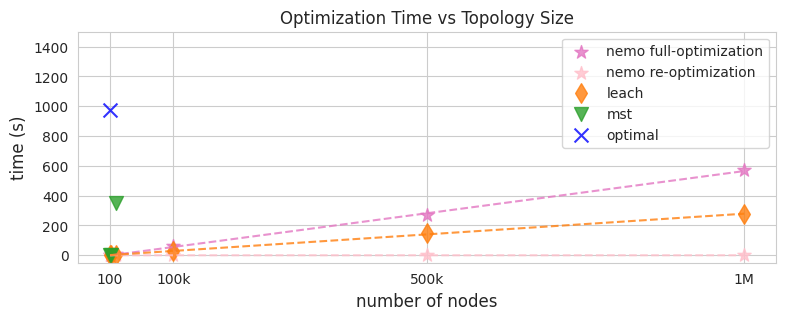

In [7]:
fig, ax = plt.subplots(figsize=(9, 3))

for k, v in approaches.items():
    # create a scatter plot
    ax.scatter(topology_sizes, v, label=k, s=100, alpha=0.8, marker=markers[k], color=colors[k])

    # calculate the linear regression line
    slope, intercept = np.polyfit(topology_sizes, v, 1)
    full_opt_line = np.poly1d((slope, intercept))(np.array(topology_sizes))
    # plot the linear regression line
    ax.plot(topology_sizes, full_opt_line, "--", alpha=0.8, color=colors[k])

# set the axis labels and title
ax.set_xlabel('number of nodes', fontsize=12)
ax.set_ylabel('time (s)', fontsize=12)

# Set the legend
ax.legend()
ax.ticklabel_format(style='plain', axis='x')

# Set the x-ticks and format the tick labels
xticks = [100, 100000, 500000, 1000000]
xtick_labels = [f"{xtick//1000}k" if xtick < 1000000 else f"{xtick//1000000}M" for xtick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Set the tick label format for the x-axis
formatter = FuncFormatter(lambda x, pos: f"{x}" if x < 1000 else f"{x//1000}k" if x < 1000000 else f"{x//1000000}M")
ax.xaxis.set_major_formatter(formatter)

ax.set_ylim([-50, 1500])

plt.savefig("plots/scalability.svg", bbox_inches = "tight")

# show the plot
plt.title('Optimization Time vs Topology Size')
plt.show()